In [1]:
import scipy.fftpack as fftpack
import numpy as np
from numpy import exp, pi
import matplotlib.pyplot as plt
from scipy.signal import convolve
%matplotlib inline

In [3]:
frequency = 3e9
p = 0.956
a = 1
b = 10e-9
c = 0
T_herm = 220e-9/6
t = np.linspace(-10*T_herm, 10*T_herm, 100000)
freq = fftpack.fftshift(fftpack.fftfreq(t.size, t[1] - t[0]))

def hermite(env_amplitude=1, T_herm=T_herm, mu=0):
    env = env_amplitude*(1-p*((t-mu)/T_herm)**2)*np.exp(-((t-mu)/T_herm)**2)
    return env

def analytic(a=a, b=b):
    '''Analytic form, produced by notebook "Analytic microwave distortion"'''
    i = -a*(p*(t/T_herm)**2 - 1)*exp(-(t/T_herm)**2)
    q = a*b*(t/T_herm**2)*(-p*(t/T_herm)**2 + p + 1)*exp(-(t/T_herm)**2)/pi
    return i, q
    
def source(i, q):
    f = i * np.cos(2 * np.pi * frequency * t) - q * np.sin(2 * np.pi * frequency * t)
    return f

def deconvolve(signal):
    i = signal * np.cos(2 * np.pi * frequency * t)
    q = signal * -np.sin(2 * np.pi * frequency * t)
    ft_i = fft(i)
    ft_q = fft(q)
    mask = abs(freq) > frequency
    ft_i[mask] = 0
    ft_q[mask] = 0
    i = ifft(ft_i).real*2
    q = ifft(ft_q).real*2
    return i, q

def fft(signal):
    dt = t[1] - t[0]
    ft = fftpack.fftshift(fftpack.fft(signal)) 
    ft *= dt * 2 # Normalization
    angle = np.angle(ft)
    mask = np.zeros(angle.size, dtype=bool)
    mask[angle>np.pi/2] = True
    mask[angle<-np.pi/2] = True
    ft[mask] *= -1 
    return ft

def ifft(ft):
    dt = t[1] - t[0]
    signal = fftpack.fftshift(fftpack.ifft(fftpack.ifftshift(ft)))
    signal /= dt * 2 # Normalization
    return signal

def check_angle(ft):
    angle = np.angle(ft)
    mask = np.zeros(angle.size, dtype=bool)
    mask[angle>np.pi/2] = True
    mask[angle<-np.pi/2] = True
    ft[mask] *= -1 
    return ft

# AWG

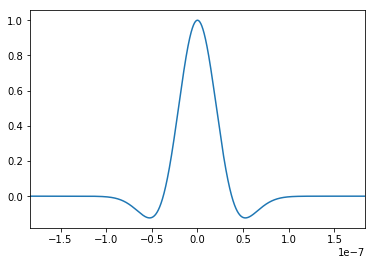

In [4]:
signal_awg = hermite()
plt.plot(t, signal_awg)
plt.xlim(-5*T_herm, 5*T_herm)
plt.show()

# RF source

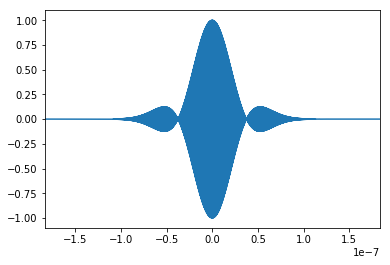

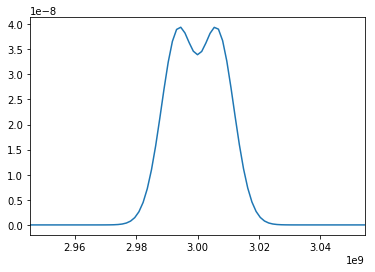

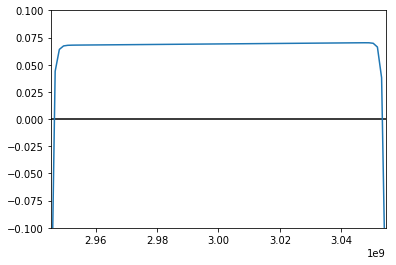

In [5]:
i, q = hermite(), 0
signal_rf = source(i, q)
plt.plot(t, signal_rf.real)
plt.xlim(-5*T_herm, 5*T_herm)
plt.show()

ft_rf = fft(signal_rf)
plt.plot(freq, abs(ft_rf))
plt.xlim(frequency-2/T_herm, frequency+2/T_herm);
plt.show()

angle_rf = np.angle(ft_rf)
plt.axhline(color='k', y=0)
plt.plot(freq, angle_rf)
plt.xlim(frequency-2/T_herm, frequency+2/T_herm);
plt.ylim(-.1,.1);

# Distortion

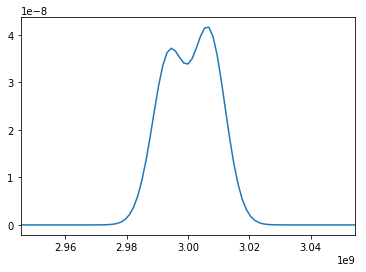

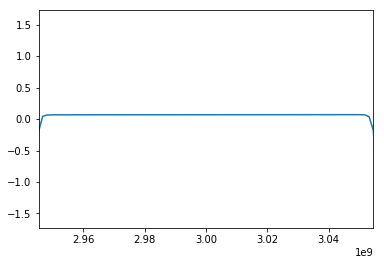

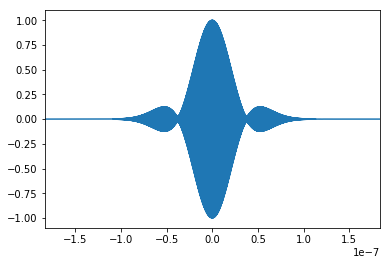

In [6]:
ft_dis = ft_rf * a * (1 + b*(abs(freq)-frequency) + c*(abs(freq)-frequency)**2)
ft_dis = check_angle(ft_dis)
plt.plot(freq, ft_dis.real)
plt.xlim(frequency-2/T_herm, frequency+2/T_herm);
plt.show()

plt.plot(freq, np.angle(ft_dis))
plt.xlim(frequency-2/T_herm, frequency+2/T_herm);
plt.show()

signal_dis = ifft(ft_dis)
plt.plot(t, signal_dis.real)
plt.xlim(-5*T_herm, 5*T_herm)
plt.show()

# Deconvolve

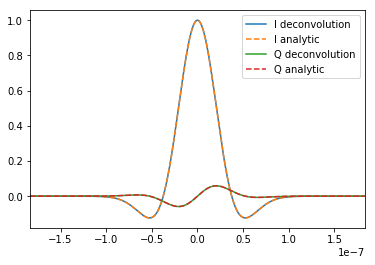

In [7]:
i, q = deconvolve(signal_dis)
i_ana, q_ana = analytic()

plt.plot(t, i, label='I deconvolution')
plt.plot(t, i_ana, '--', label='I analytic')
plt.plot(t, q, label='Q deconvolution')
plt.plot(t, q_ana,'--', label='Q analytic')
plt.legend()
plt.xlim(-5*T_herm, 5*T_herm)
plt.show()

# Check

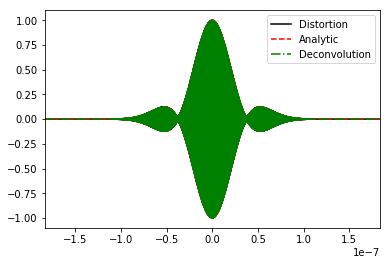

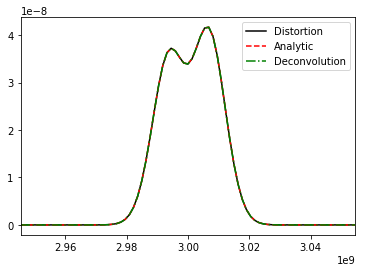

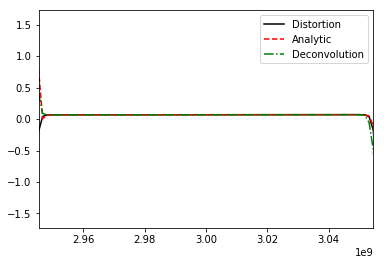

In [8]:
signal_repr = source(i.real, q.real)
signal_ana = source(i_ana.real, q_ana.real)
plt.plot(t, signal_dis.real, 'k', label='Distortion')
plt.plot(t, signal_ana.real, 'r--', label='Analytic')
plt.plot(t, signal_repr.real, 'g-.', label='Deconvolution')
plt.xlim(-5*T_herm, 5*T_herm)
plt.legend()
plt.show()

ft_repr = fft(signal_repr.real)
ft_ana = fft(signal_ana)
plt.plot(freq, abs(ft_dis), 'k', label='Distortion')
plt.plot(freq, abs(ft_ana),'r--', label='Analytic')
plt.plot(freq, abs(ft_repr), 'g-.', label='Deconvolution')
plt.xlim(frequency-2/T_herm, frequency+2/T_herm);
plt.legend()
plt.show()

plt.plot(freq, np.angle(ft_dis), 'k', label='Distortion')
plt.plot(freq, np.angle(ft_ana), 'r--', label='Analytic')
plt.plot(freq, np.angle(ft_repr), 'g-.', label='Deconvolution')
plt.xlim(frequency-2/T_herm, frequency+2/T_herm);
plt.legend()
plt.show()